Survival Analysis attempts to measure the time until an event occurs, making it an excellent approach to the modeling of customer churn. While there have been many attempts to taylor traditional machine learning approaches to Survival Analysis - most notably via Random Survival Forests - it has been a well researched and developed area in statistics. In this Analysis I will mostly focus on the latter approach, primarily through Cox's Proportional Hazards Model. The data comes from an Iranian Telecom Company, courtesy of the UCI Machine Learning Repository, from where it is freely available.

In [1]:
#Specific Importations
from lifelines import CoxPHFitter
import sksurv
import sksurv.util
import sksurv.ensemble
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sksurv.linear_model import CoxnetSurvivalAnalysis

#General Importations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print('Done')

Done


We begin with some basic data exploration.

In [2]:
df = pd.read_csv("Customer Churn.csv" )
df

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,21,0,19,2,6697,147,92,44,2,2,1,25,721.980,0
3146,17,0,17,1,9237,177,80,42,5,1,1,55,261.210,0
3147,13,0,18,4,3157,51,38,21,3,1,1,30,280.320,0
3148,7,0,11,2,4695,46,222,12,3,1,1,30,1077.640,0


After a quick peek at the data it becomes apparent that the binary categorical columns 'Tariff Plan' and 'Status' are coded to 1 and 2 instead of the generic 1s and 0s. We quickly convert them.

In [3]:
#Converting the Columns

df['Tariff Plan'] = (df['Tariff Plan'] == 2)*1
df['Status'] = (df['Status'] == 1)*1

print(df['Tariff Plan'].unique())
print(df['Status'].unique())

[0 1]
[1 0]


The source of the dataset said it contained no nulls, but it is always good practice to check.

In [4]:
#Checking for null values
df.isnull().sum()

Call  Failure              0
Complains                  0
Subscription  Length       0
Charge  Amount             0
Seconds of Use             0
Frequency of use           0
Frequency of SMS           0
Distinct Called Numbers    0
Age Group                  0
Tariff Plan                0
Status                     0
Age                        0
Customer Value             0
Churn                      0
dtype: int64

Next, we check for proper Datatypes.

In [5]:
#Checking for correct Dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call  Failure            3150 non-null   int64  
 1   Complains                3150 non-null   int64  
 2   Subscription  Length     3150 non-null   int64  
 3   Charge  Amount           3150 non-null   int64  
 4   Seconds of Use           3150 non-null   int64  
 5   Frequency of use         3150 non-null   int64  
 6   Frequency of SMS         3150 non-null   int64  
 7   Distinct Called Numbers  3150 non-null   int64  
 8   Age Group                3150 non-null   int64  
 9   Tariff Plan              3150 non-null   int32  
 10  Status                   3150 non-null   int32  
 11  Age                      3150 non-null   int64  
 12  Customer Value           3150 non-null   float64
 13  Churn                    3150 non-null   int64  
dtypes: float64(1), int32(2),

We take a quick look at some descriptive statistics for the dataset.

In [6]:
#Very Brief Exploration, in a full analysis it is good practice for one to make some plots and explore the variables and their relationships visually at this stage
df.describe()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
count,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000
mean,7.627937,0.076508,32.541905,0.942857,4472.459683,69.460635,73.174921,23.509841,2.826032,0.077778,0.751746,30.998413,470.972916,0.157143
std,7.263886,0.265851,8.573482,1.521072,4197.908687,57.413308,112.237560,17.217337,0.892555,0.267864,0.432069,8.831095,517.015433,0.363993
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,15.000000,0.000000,0.000000
25%,1.000000,0.000000,30.000000,0.000000,1391.250000,27.000000,6.000000,10.000000,2.000000,0.000000,1.000000,25.000000,113.801250,0.000000
50%,6.000000,0.000000,35.000000,0.000000,2990.000000,54.000000,21.000000,21.000000,3.000000,0.000000,1.000000,30.000000,228.480000,0.000000
75%,12.000000,0.000000,38.000000,1.000000,6478.250000,95.000000,87.000000,34.000000,3.000000,0.000000,1.000000,30.000000,788.388750,0.000000
max,36.000000,1.000000,47.000000,10.000000,17090.000000,255.000000,522.000000,97.000000,5.000000,1.000000,1.000000,55.000000,2165.280000,1.000000


Nothing seems to be out of the ordinary, we are now ready to begin modeling.

We Begin with a plain Cox Proportional Hazard Model, a semi-parametric approach that is very popular as the 'Gold Standard' for these types of analyses.

In [7]:
#Fitting the model
cph = CoxPHFitter()
cph.fit(df, duration_col = 'Subscription  Length', event_col = 'Churn')

<lifelines.CoxPHFitter: fitted with 3150 total observations, 2655 right-censored observations>

While we often don't care about violations of the proportional hazards assumptions in the context of prediction and predictive analytics, it is important for inferential settings. The lifelines library has a great functionality for this purpose


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3150 total observations, 2655 right-censored observations>
         test_name = proportional_hazard_test

---
                              test_statistic      p  -log2(p)
Age                     km             16.51 <0.005     14.33
                        rank           23.10 <0.005     19.31
Age Group               km             10.79 <0.005      9.94
                        rank           12.13 <0.005     10.98
Call  Failure           km             10.33 <0.005      9.58
                        rank           10.53 <0.005      9.74
Charge  Amount          km             33.84 <0.005     27.32
                        rank           32.20 <0.005     26.10
Complains               km             20.39 <0.005     17.27
                        rank           34.44 <0.005     27.76
Customer Value          km              6.26   0.01      6.34
                        rank            1.92   0.17      2.60
Distinct Called Numbers km              6.48   0.01      6.52
                        rank            8.22 <0.005      7.92
Frequency of SMS        km              5.64   0.02      5.84
                        rank            1.47   0.23      2.15
Frequency of use        km              7.18   0.01      7.08
                        rank            4.53   0.03      4.91
Seconds of Use          km             15.22 <0.005     13.35
                        rank            8.74 <0.005      8.33
Status                  km             11.34 <0.005     10.37
                        rank           27.77 <0.005     22.80
Tariff Plan             km              0.16   0.69      0.53
                        rank            0.21   0.64      0.63



1. Variable 'Call  Failure' failed the non-proportional test: p-value is 0.0012.

   Advice 1: the functional form of the variable 'Call  Failure' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Call  Failure' using pd.cut, and then specify it in
`strata=['Call  Failure', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'Complains' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['Complains', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment..

[[<AxesSubplot: xlabel='rank-transformed time\n(p=0.0012)'>,
  <AxesSubplot: xlabel='km-transformed time\n(p=0.0013)'>],
 [<AxesSubplot: xlabel='rank-transformed time\n(p=0.0000)'>,
  <AxesSubplot: xlabel='km-transformed time\n(p=0.0000)'>],
 [<AxesSubplot: xlabel='rank-transformed time\n(p=0.0000)'>,
  <AxesSubplot: xlabel='km-transformed time\n(p=0.0000)'>],
 [<AxesSubplot: xlabel='rank-transformed time\n(p=0.0031)'>,
  <AxesSubplot: xlabel='km-transformed time\n(p=0.0001)'>],
 [<AxesSubplot: xlabel='rank-transformed time\n(p=0.0333)'>,
  <AxesSubplot: xlabel='km-transformed time\n(p=0.0074)'>],
 [<AxesSubplot: xlabel='rank-transformed time\n(p=0.2260)'>,
  <AxesSubplot: xlabel='km-transformed time\n(p=0.0175)'>],
 [<AxesSubplot: xlabel='rank-transformed time\n(p=0.0041)'>,
  <AxesSubplot: xlabel='km-transformed time\n(p=0.0109)'>],
 [<AxesSubplot: xlabel='rank-transformed time\n(p=0.0005)'>,
  <AxesSubplot: xlabel='km-transformed time\n(p=0.0010)'>],
 [<AxesSubplot: xlabel='rank-tra

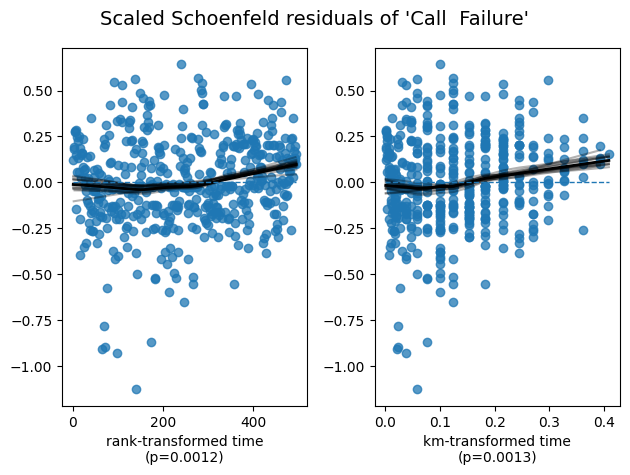

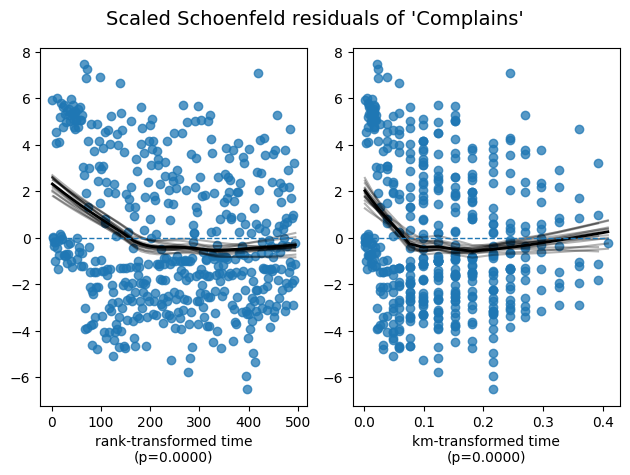

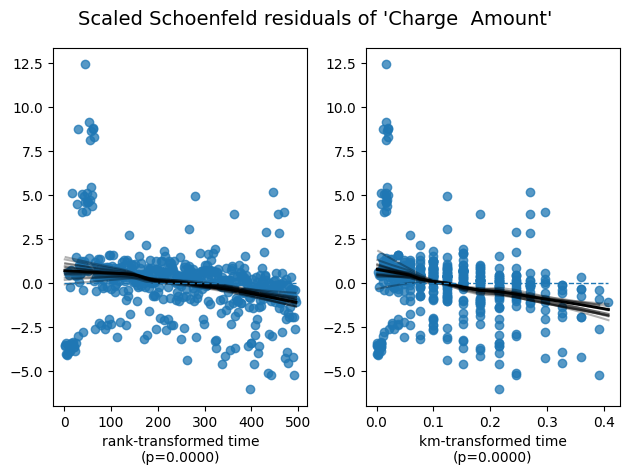

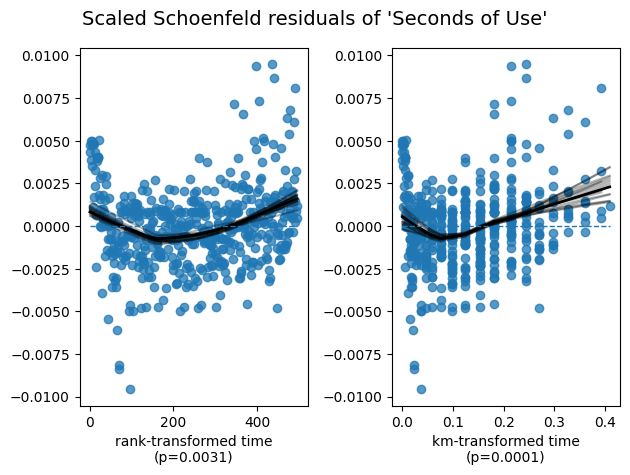

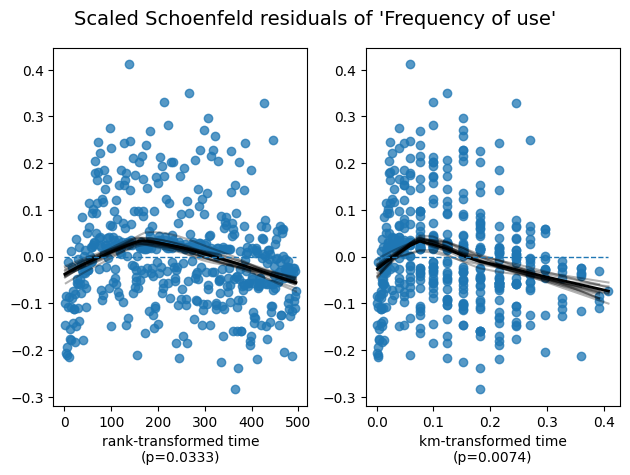

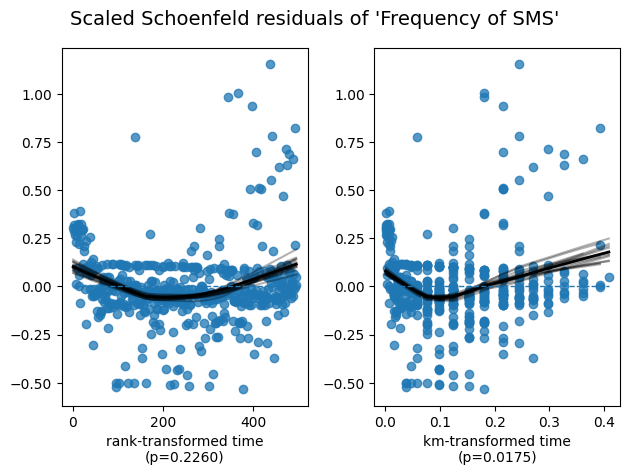

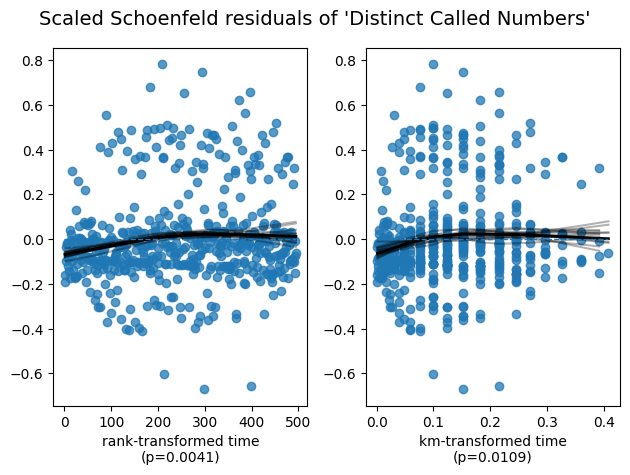

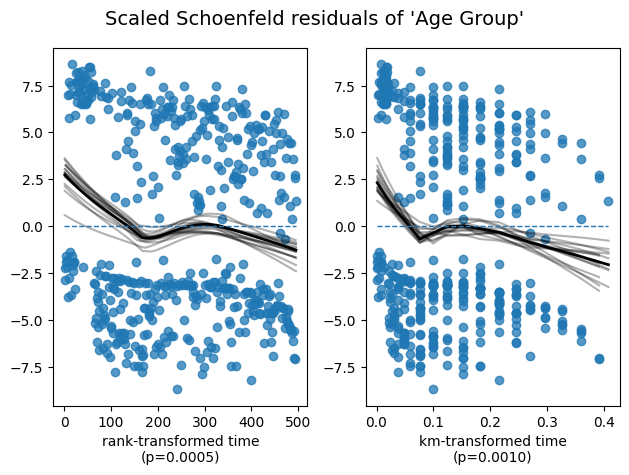

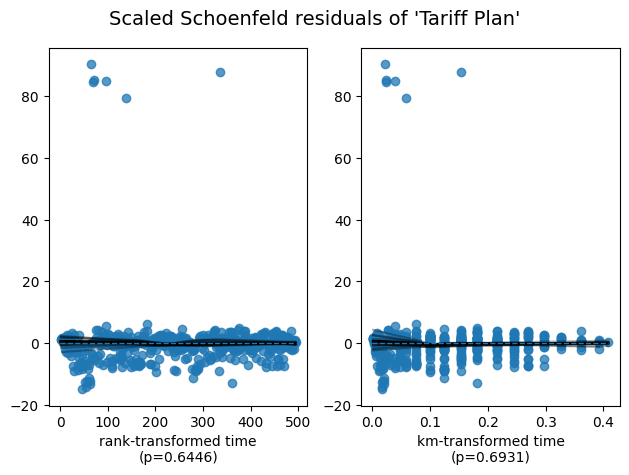

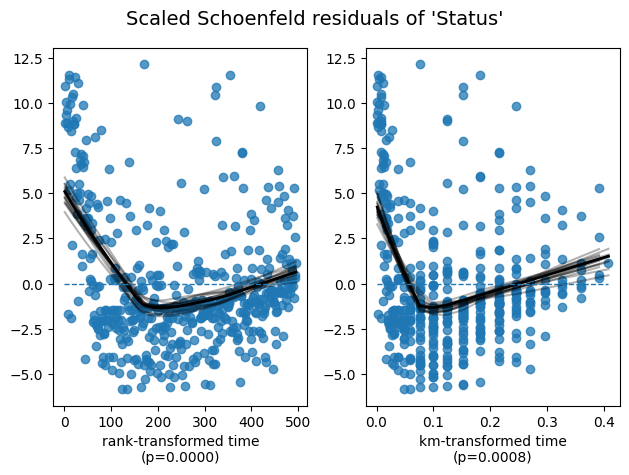

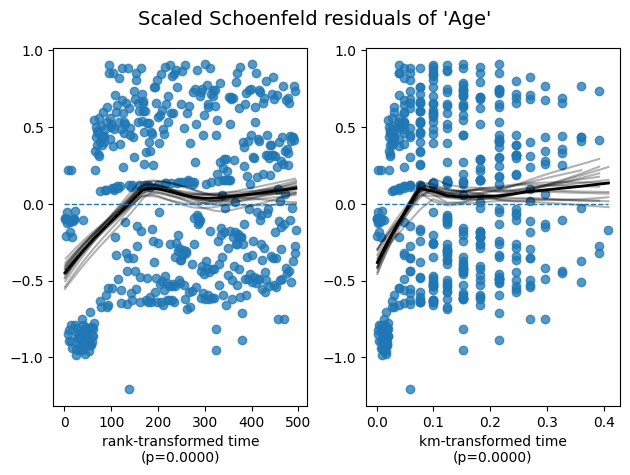

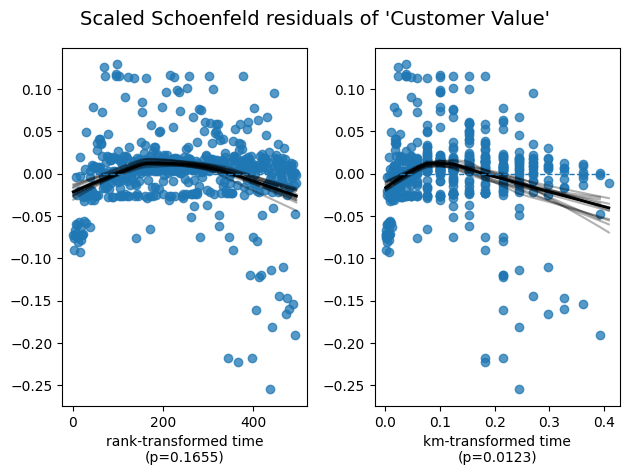

In [8]:

cph.check_assumptions(df, p_value_threshold= 0.05, show_plots= True)

However, because I am more concerned about predictive accuracy in this setting, we will essentially ignore the above violations. Furthermore, there's good reason to believe that essentially any dataset you will every use will violate this assumption. See Stensrud MJ, Hernán MA. Why Test for Proportional Hazards? JAMA. 2020;323(14):1401–1402. doi:10.1001/jama.2020.1267

 

In [9]:
# Print some Summary Statistics of the Model
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 3150 total observations, 2655 right-censored observations>
             duration col = 'Subscription  Length'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 3150
number of events observed = 495
   partial log-likelihood = -3052.11
         time fit was run = 2023-10-08 22:22:21 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
Call  Failure             0.07       1.07       0.01             0.05             0.09                 1.05                 1.10
Complains                 1.82       6.15       0.11             1.60             2.03                 4.96                 7.63
Charge  Amount           -0.29       0.75       0.09            -0.47            -0.11                 0.62                 0.90
Seconds of Use            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Frequency of use         -0.04       0.96       0.01            -0.05            -0.03                 0.95                 0.97
Frequency of SMS         -0.03       0.97       0.01            -0.05            -0.01                 0.96                 0.99
Distinct Called Numbers  -0.02       0.98       0.01            -0.04            -0.01                 0.96                 0.99
Age Group                -0.47       0.63       0.20            -0.85            -0.08                 0.43                 0.92
Tariff Plan               0.99       2.70       0.45             0.12             1.87                 1.13                 6.48
Status                    0.08       1.08       0.16            -0.23             0.39                 0.79                 1.48
Age                       0.03       1.04       0.02            -0.01             0.08                 0.99                 1.08
Customer Value            0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01

                          cmp to     z      p   -log2(p)
covariate                                               
Call  Failure               0.00  6.56 <0.005      34.09
Complains                   0.00 16.53 <0.005     201.55
Charge  Amount              0.00 -3.15 <0.005       9.27
Seconds of Use              0.00  0.88   0.38       1.40
Frequency of use            0.00 -6.75 <0.005      35.97
Frequency of SMS            0.00 -2.76   0.01       7.44
Distinct Called Numbers     0.00 -2.66   0.01       7.01
Age Group                   0.00 -2.38   0.02       5.86
Tariff Plan                 0.00  2.23   0.03       5.26
Status                      0.00  0.50   0.62       0.69
Age                         0.00  1.61   0.11       3.21
Customer Value              0.00  1.62   0.10       3.25
---
Concordance = 0.88
Partial AIC = 6128.22
log-likelihood ratio test = 1090.03 on 12 df
-log2(p) of ll-ratio test = 747.74

One can see from the summary that Harrel's Concordance index for the model is 0.88, not a bad result! However, it's possible to improve this with some regularization. To do this, we build a similar model from the sklearn-survival package to perform a gridsearch for hyperparameter tuning. We search for both the optimal penalty and L1 ratio for the elastic net.

In [10]:
# The implementation of the response requires a specific structured array which can be constructed from a dataframe via one of the package's utilities
X = df[df.columns.drop(['Churn', 'Subscription  Length'])]
Y = sksurv.util.Surv.from_dataframe('Churn', 'Subscription  Length', df)


In [11]:
# Make and Fit the Pipe
coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, max_iter=500))

coxnet_pipe.fit(X, Y)

C:\Users\Navid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\pipeline.py:420: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=500).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, max_iter=500))])

In [ ]:
# Retrieve the alphas and perform hyperparameter search

estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis()),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas], 'coxnetsurvivalanalysis__l1_ratio' : [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]},
    cv=cv,
).fit(X, Y)

In [13]:
# Return the optimal hyperparameters
gcv.best_params_

{'coxnetsurvivalanalysis__alphas': [0.004084801698654548],
 'coxnetsurvivalanalysis__l1_ratio': 1.0}

The search came up with a full Lasso penalty, but a very small one, indicating the model performance does not meaningfully improve with regularization. The plot below visualizes this.

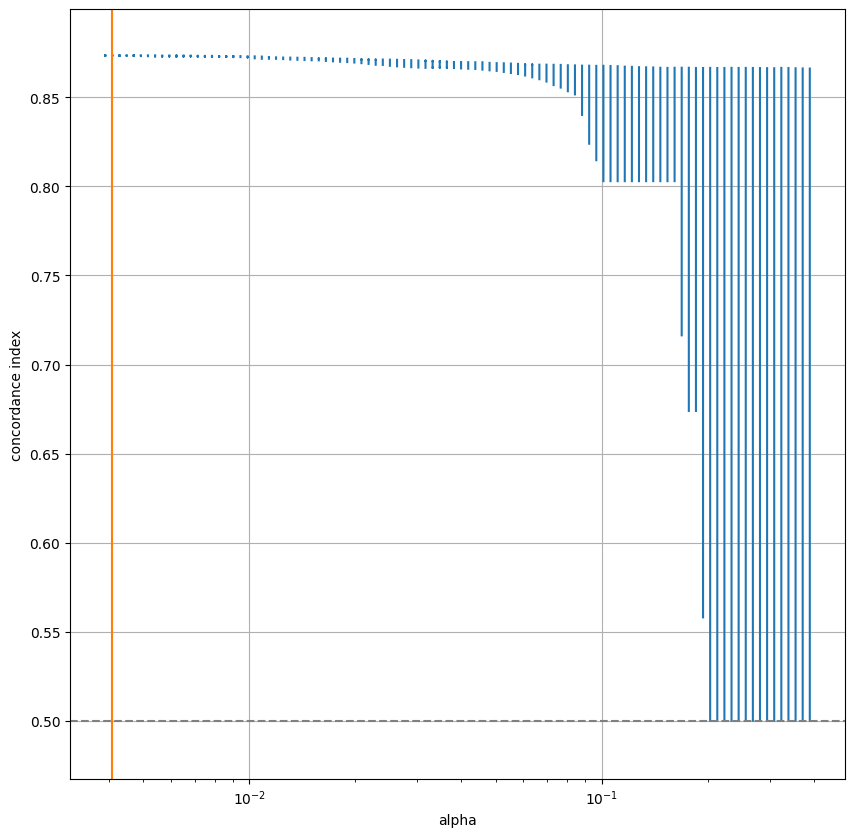

In [14]:
# Plotting the Grid Search Results for the Penalty

cv_results = pd.DataFrame(gcv.cv_results_)

alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

We now return to the lifelines implementation, and fit it with the optimized hyperparameters.

In [15]:
# Fit the Model
cph = CoxPHFitter(penalizer=0.004, l1_ratio=1.0)
cph.fit(df, duration_col = 'Subscription  Length', event_col = 'Churn')

<lifelines.CoxPHFitter: fitted with 3150 total observations, 2655 right-censored observations>

In [16]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 3150 total observations, 2655 right-censored observations>
             duration col = 'Subscription  Length'
                event col = 'Churn'
                penalizer = 0.004
                 l1 ratio = 1.0
      baseline estimation = breslow
   number of observations = 3150
number of events observed = 495
   partial log-likelihood = -3110.32
         time fit was run = 2023-10-08 22:23:41 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
Call  Failure             0.03       1.04       0.01             0.02             0.05                 1.02                 1.05
Complains                 1.83       6.25       0.11             1.62             2.05                 5.05                 7.74
Charge  Amount           -0.10       0.90       0.08            -0.25             0.05                 0.78                 1.05
Seconds of Use           -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Frequency of use         -0.02       0.98       0.00            -0.03            -0.01                 0.97                 0.99
Frequency of SMS         -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
Distinct Called Numbers  -0.03       0.97       0.01            -0.04            -0.01                 0.96                 0.99
Age Group                -0.22       0.80       0.06            -0.34            -0.10                 0.71                 0.90
Tariff Plan               0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Status                   -0.05       0.95       0.15            -0.34             0.24                 0.71                 1.27
Age                      -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Customer Value           -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00

                          cmp to     z      p   -log2(p)
covariate                                               
Call  Failure               0.00  3.96 <0.005      13.72
Complains                   0.00 16.77 <0.005     207.26
Charge  Amount              0.00 -1.35   0.18       2.50
Seconds of Use              0.00 -0.00   1.00       0.00
Frequency of use            0.00 -6.14 <0.005      30.18
Frequency of SMS            0.00 -5.16 <0.005      21.98
Distinct Called Numbers     0.00 -3.35 <0.005      10.28
Age Group                   0.00 -3.65 <0.005      11.89
Tariff Plan                 0.00  0.00   1.00       0.00
Status                      0.00 -0.32   0.75       0.42
Age                         0.00 -0.00   1.00       0.00
Customer Value              0.00 -0.00   1.00       0.00
---
Concordance = 0.88
Partial AIC = 6244.64
log-likelihood ratio test = 973.61 on 12 df
-log2(p) of ll-ratio test = 664.57

As expected from our search results and the graph, the Concordance Index did not improve with regularization. We now briefly compare our results with another popular method of modeling this type of problem, a Random Survival Forest. This is of course a slightly tweaked version of a Random Forest model, a very popular and effective approach in Machine Learning.

In [17]:
#Split the data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [18]:
''' 

A more rigorous analysis would use a cross validated grid search to choose an optimal m subset of the p predictors for the random forest, as m is a tunable hyperparameter. 
However, this is very computationally expensive/ time consuming, so in an effort keep this notebook's runtime low, I will simply go by using the square root of p, which often serves as a good 
'rule of thumb'. 

'''

rsf = sksurv.ensemble.RandomSurvivalForest(n_estimators= 1000, max_features= 'sqrt', random_state= 1) # Set random state for reproducibility
rsf.fit(x_train,y_train)


RandomSurvivalForest(n_estimators=1000, random_state=1)

In [19]:
rsf.score(x_test,y_test)

0.9401770977967567

The Random Survival Forest performs well, achieving a Concordance Index of 94 % on a test set! This is a respectable improvement in prediction accuracy over the Cox model. Unfortunately, the current version of the software package does not allow us to view the feature/variable importance, an important tool if our goal was inferential.

In [20]:
# Uncomment the line below to observe the error

# rsf.feature_importances_ 

By contrast and as we have seen from the summary functionality, the Proportional Hazards model is far superior in terms of interpretation of results. Plotting is also very straightforward.

<AxesSubplot: xlabel='log(HR) (95% CI)'>

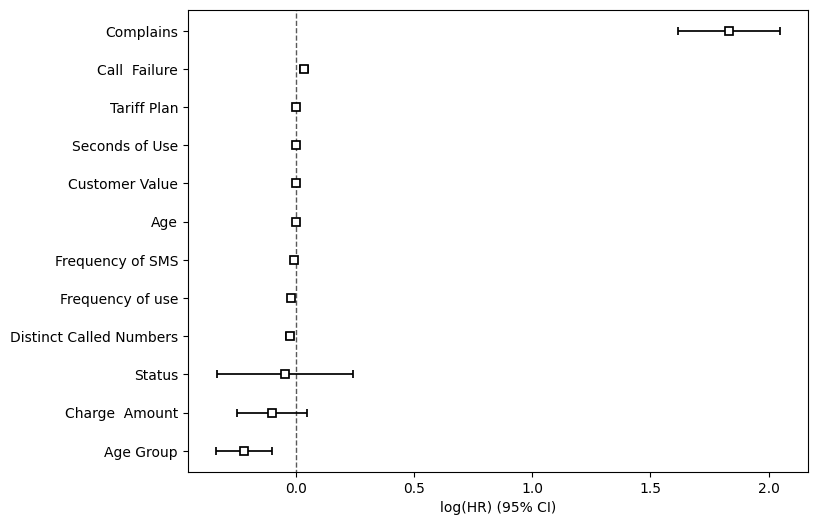

In [21]:
ax = plt.subplots(figsize=(8, 6))
cph.plot(ax=ax[1])

As a brief example, we plot the effects of belonging to a particular age group, which the company that collected the data binned ordinally.

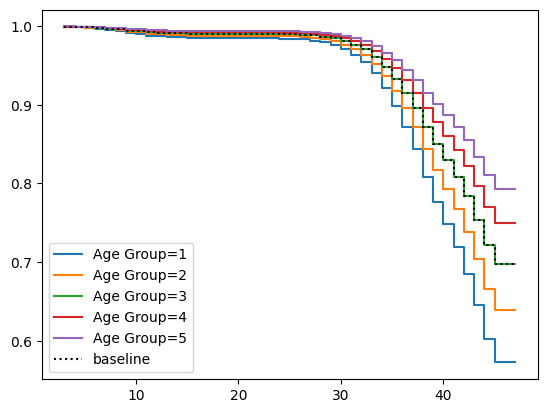

In [22]:
cph.plot_partial_effects_on_outcome('Age Group', values=["1", "2", "3", '4', '5'], plot_baseline=True, y= 'survival_function');

One can see a notable separation of the survival function of the different age groups, especially past a subscription time of 30 months, an insight which wouldn't have come about from the survival forest. Ultimately, the choice between either of the models depends on the task at hand and the trade-off between prediction accuracy and inference. Moreover, there exists a plethora other models that can be used for survival analysis, which will not be comprehensively examined here. Most popular among these are Survival SVMs (an analogue of Support Vector Machines for survival analysis) , deep learning models, and a few other generalized linear models such as those based on Gamma or Weibull distributions. Additionally, one can approach the modeling of Customer Churn in a completely different manner, as a problem of Classification, as opposed to the Survival Analysis approach considered here.